# MODEL CONSTRUCTION

In [1]:
import pandas as pd
import numpy as np
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn import metrics
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE


In [2]:
FEATURES_PATH = "../data/output/features.csv"
TIME_TO_BUG_PATH = "../data/output/time_to_bug.csv"

SPARK_3_0_0_PREVIEW_RELEASE  = pd.to_datetime("Oct 29, 2019") 
SPARK_3_0_0_PREVIEW2_RELEASE = pd.to_datetime("Dec 16, 2019") 
SPARK_3_0_0_RELEASE          = pd.to_datetime("Jun 05, 2020") 
SPARK_3_0_1_RELEASE          = pd.to_datetime("Aug 27, 2020")

## Import Data

In [3]:
features = pd.read_csv(FEATURES_PATH, index_col="File")
features.head()

,LinesCount,LinesAvgLength,LineCodeProportion,LineBlankProportion,TypesCount,ClassProportion,TraitProportion,MaxChildren,MethodCount,PrivateMethodProportion,ProtectedMethodProportion,MethodOverrideProportion,FinalMethodProportion,VarLocalCount,VarFieldCount,MagicNumbersCount
File,,,,,,,,,,,,,,,,
common/sketch/src/test/scala/org/apache/spark/util/sketch/BloomFilterSuite.scala,134,34,0.634328,0.253731,1,1.000000,0.000000,1,4,0.250000,0.000000,0.000000,0.0,0,0,17
common/sketch/src/test/scala/org/apache/spark/util/sketch/CountMinSketchSuite.scala,152,31,0.657895,0.243421,1,1.000000,0.000000,1,4,0.250000,0.000000,0.000000,0.0,0,0,14
core/src/test/scala/org/apache/spark/AccumulatorSuite.scala,205,33,0.702439,0.146341,3,0.666667,0.000000,1,12,0.000000,0.000000,0.333333,0.0,0,3,3
core/src/test/scala/org/apache/spark/BarrierStageOnSubmittedSuite.scala,262,35,0.843511,0.087786,1,1.000000,0.000000,1,2,1.000000,0.000000,0.000000,0.0,0,0,35
core/src/test/scala/org/apache/spark/CheckpointSuite.scala,645,41,0.784496,0.130233,7,0.714286,0.142857,2,24,0.166667,0.416667,0.125000,0.0,0,1,8


In [4]:

time_to_bug = pd.read_csv(TIME_TO_BUG_PATH, index_col="File")["DTCreated"].map(lambda dt : pd.to_timedelta(dt))
time_to_bug.head()

File
common/sketch/src/test/scala/org/apache/spark/util/sketch/BloomFilterSuite.scala                    NaT
common/sketch/src/test/scala/org/apache/spark/util/sketch/CountMinSketchSuite.scala                 NaT
core/src/test/scala/org/apache/spark/AccumulatorSuite.scala                                         NaT
core/src/test/scala/org/apache/spark/BarrierStageOnSubmittedSuite.scala               279 days 05:53:00
core/src/test/scala/org/apache/spark/CheckpointSuite.scala                                          NaT
Name: DTCreated, dtype: timedelta64[ns]

## Preparing the independent variables
Lets group our observations into the following ordinal categories:
- 0: from v3.0-preview  to v3.0-preview2
- 1: from v3.0-preview2 to v3.0.0
- 2: from v3.0.0        to v3.0.1
- 3: after v3.0.1

<AxesSubplot:title={'center':'y Frequency Distribution'}, xlabel='y', ylabel='Count'>

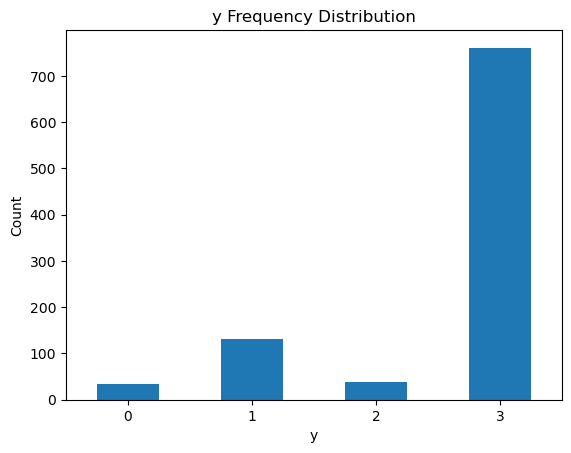

In [5]:
periods =[SPARK_3_0_0_PREVIEW_RELEASE  - SPARK_3_0_0_PREVIEW_RELEASE, 
          SPARK_3_0_0_PREVIEW2_RELEASE - SPARK_3_0_0_PREVIEW_RELEASE,
          SPARK_3_0_0_RELEASE          - SPARK_3_0_0_PREVIEW_RELEASE,
          SPARK_3_0_1_RELEASE          - SPARK_3_0_0_PREVIEW_RELEASE]
          # SPARK_3_0_0_RELEASE          - SPARK_3_0_0_PREVIEW_RELEASE]

def match_period(dt):
    for i in range(len(periods) - 1):
        if (periods[i] < dt) \
          and (periods[i+1] >= dt):
            return i
    return len(periods) - 1

y = time_to_bug.map(match_period)

y.to_csv("../data/output/y.csv")

y.value_counts().sort_index().plot.bar(title="y Frequency Distribution",
                                       xlabel="y",
                                       ylabel="Count",
                                       rot=1)

## Shuffling the Dataset

In [6]:
dataset = features
dataset["y"] = y

dataset = dataset.sample(frac=1, random_state=0)
dataset

,LinesCount,LinesAvgLength,LineCodeProportion,LineBlankProportion,TypesCount,ClassProportion,TraitProportion,MaxChildren,MethodCount,PrivateMethodProportion,ProtectedMethodProportion,MethodOverrideProportion,FinalMethodProportion,VarLocalCount,VarFieldCount,MagicNumbersCount,y
File,,,,,,,,,,,,,,,,,
sql/core/src/test/scala/org/apache/spark/sql/execution/datasources/v2/FileTableSuite.scala,88,43,0.681818,0.147727,2,1.0,0.0,1,7,0.000000,0.0,1.000000,0.0,0,0,0,3
mllib/src/test/scala/org/apache/spark/ml/feature/IDFSuite.scala,127,34,0.740157,0.141732,1,1.0,0.0,1,1,0.000000,0.0,0.000000,0.0,0,0,5,3
core/src/test/scala/org/apache/spark/ImplicitOrderingSuite.scala,83,47,0.686747,0.132530,5,0.8,0.0,1,4,0.000000,0.0,0.500000,0.0,0,0,2,3
sql/core/src/test/scala/org/apache/spark/sql/execution/benchmark/DataSourceReadBenchmark.scala,569,36,0.787346,0.168717,1,0.0,0.0,1,14,0.357143,0.0,0.142857,0.0,6,0,3,3
mllib/src/test/scala/org/apache/spark/mllib/feature/StandardScalerSuite.scala,373,44,0.753351,0.206434,1,1.0,0.0,1,1,1.000000,0.0,0.000000,0.0,0,0,34,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sql/core/src/test/scala/org/apache/spark/sql/test/GenericFlatSpecSuite.scala,47,36,0.489362,0.127660,1,1.0,0.0,1,1,1.000000,0.0,0.000000,0.0,0,0,0,3
core/src/test/scala/org/apache/spark/util/logging/DriverLoggerSuite.scala,78,32,0.628205,0.179487,1,1.0,0.0,1,3,0.333333,0.0,0.666667,0.0,0,1,0,3
sql/core/src/test/scala/org/apache/spark/sql/connector/AlterTableTests.scala,1143,33,0.811899,0.174978,1,0.0,1.0,1,2,0.500000,0.5,0.000000,0.0,0,0,0,1


## Training the baseline model
First, lets create our training and testing sets for 10-fold cross validation.

In [7]:
sets = np.array_split(dataset,10)

train_sets = []
test_sets = []
for i in range(10):
    train_sets.append( pd.concat(sets[:i] + sets[i+1:]) )
    test_sets.append( sets[i] )

Lets train a model for each of our training sets.

In [8]:
predicted_list = list()
for i in range(10):
    mod_log = OrderedModel(train_sets[i].y, train_sets[i].drop("y", axis=1), distr='logit')
    res_log = mod_log.fit(method='bfgs', disp=False)
    
    predicted_list.append(res_log.model.predict(res_log.params, exog=test_sets[i].drop("y", axis=1)))

/home/school/opt/miniconda3/envs/ds/lib/python3.10/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  xb = xb[:, None]
/home/school/opt/miniconda3/envs/ds/lib/python3.10/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  xb = xb[:, None]
/home/school/opt/miniconda3/envs/ds/lib/python3.10/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  xb = xb[:, None]
/home/school/opt/miniconda3/envs/ds/lib/python3.10/site-packages/st

## Evaluating the baseline model

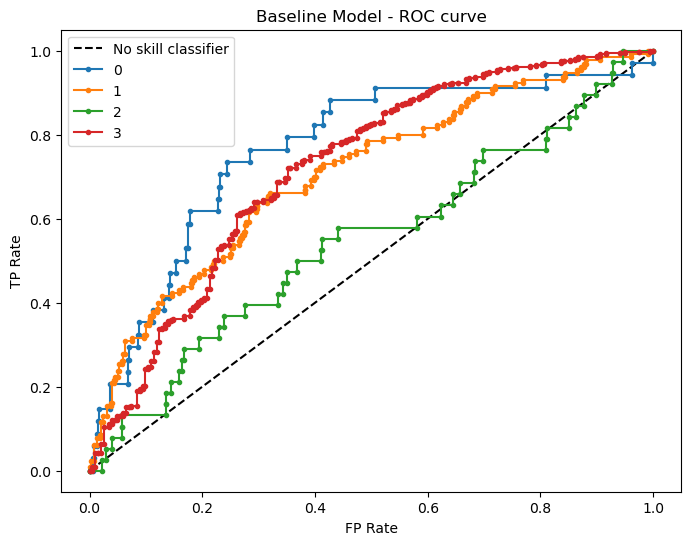

,Baseline ROC-AUC
0,0.765371
1,0.707378
2,0.547568
3,0.720951


In [9]:
y_predicted = np.concatenate(predicted_list)
y_true = np.concatenate(test_sets)[:, -1]

plt.figure(figsize=(8, 6))
plt.subplot()
plt.plot([0, 1], [0, 1], 'k--', label='No skill classifier')
for i in range(len(periods)):
    fpr, tpr, thresholds = metrics.roc_curve(y_true == i, y_predicted[:, i])
    plt.plot(fpr, tpr, marker='.', label=i)

plt.xlabel('FP Rate')
plt.ylabel('TP Rate')
plt.title("Baseline Model - ROC curve")
plt.legend()    
plt.show()

aucs = pd.DataFrame(index=range(len(periods)), columns=["Baseline ROC-AUC"])
for i in range(len(periods)):
    aucs.loc[i, "Baseline ROC-AUC"]   = metrics.roc_auc_score(y_true == i, y_predicted[:, i])
aucs

## Balancing the data

In [10]:
smote_sets = []
oversampled_sets = []

for ts in train_sets:
    smote = SMOTE(random_state=1)
    resampled_x, resampled_y = smote.fit_resample(ts.drop("y", axis = 1), ts.y)
    smote_sets.append(pd.merge(resampled_x, resampled_y, left_index=True, right_index=True))

    ros = RandomOverSampler()
    resampled_x, resampled_y = ros.fit_resample(ts.drop("y", axis = 1), ts.y)
    oversampled_sets.append(pd.merge(resampled_x, resampled_y, left_index=True, right_index=True))


## Training the model with the  balanced data

In [11]:
smote_predicted_list = list()
oversampled_predicted_list = list()
for i in range(10):
    mod_log = OrderedModel(smote_sets[i].y, smote_sets[i].drop("y", axis=1), distr='logit')
    res_log = mod_log.fit(method='bfgs', disp=False)

    smote_predicted_list.append(res_log.model.predict(res_log.params, exog=test_sets[i].drop("y", axis=1)))

    mod_log = OrderedModel(oversampled_sets[i].y, oversampled_sets[i].drop("y", axis=1), distr='logit')
    res_log = mod_log.fit(method='bfgs', disp=False)

    oversampled_predicted_list.append(res_log.model.predict(res_log.params, exog=test_sets[i].drop("y", axis=1)))

/home/school/opt/miniconda3/envs/ds/lib/python3.10/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  xb = xb[:, None]
/home/school/opt/miniconda3/envs/ds/lib/python3.10/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  xb = xb[:, None]
/home/school/opt/miniconda3/envs/ds/lib/python3.10/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  xb = xb[:, None]
/home/school/opt/miniconda3/envs/ds/lib/python3.10/site-packages/st

## Evaluating the models trained on rebalanced data

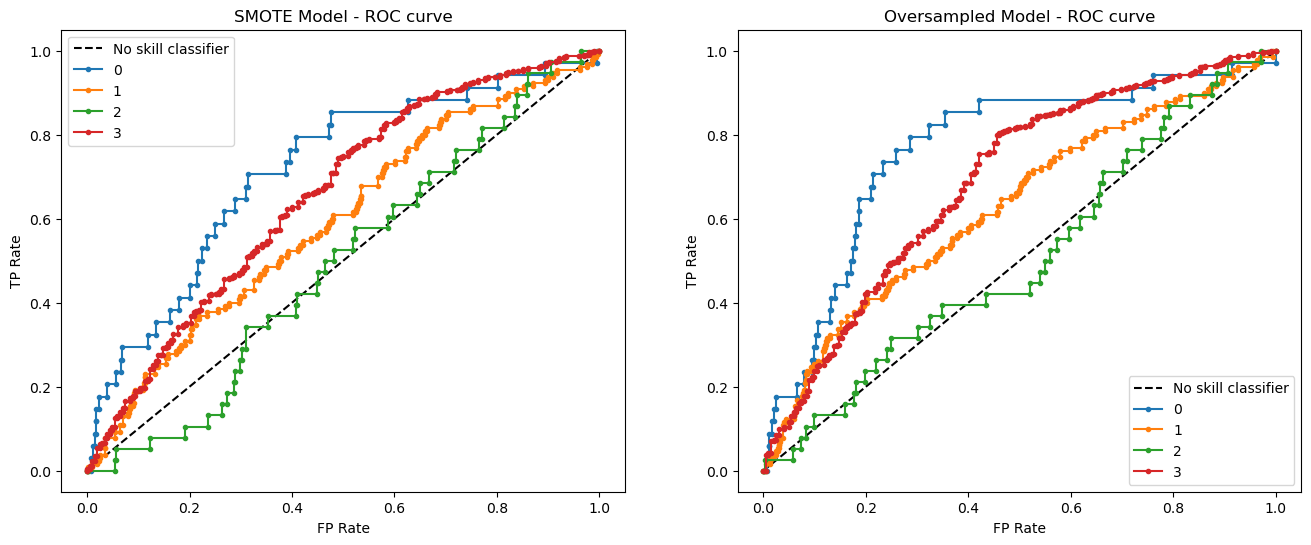

,Baseline ROC-AUC,SMOTE ROC-AUC,Oversampled ROC-AUC
0,0.765371,0.716615,0.765339
1,0.707378,0.59409,0.628682
2,0.547568,0.493371,0.507994
3,0.720951,0.655462,0.689921


In [12]:
def plot_roc(y_true, y_predicted, axe, label):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_predicted)
    axe.plot(fpr, tpr, marker='.', label=label)

y_smote_predicted = np.concatenate(smote_predicted_list)
y_oversampled_predicted = np.concatenate(oversampled_predicted_list)
y_true = np.concatenate(test_sets)[:, -1]

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(16,6)
for i in range(2):
    axs[i].plot([0, 1], [0, 1], 'k--', label='No skill classifier')
    axs[i].set(xlabel='FP Rate', ylabel='TP Rate')
axs[0].set_title("SMOTE Model - ROC curve")
axs[1].set_title("Oversampled Model - ROC curve")

for i in range(len(periods)):
    plot_roc(y_true == i, y_smote_predicted[:, i]      , axs[0], i)
    plot_roc(y_true == i, y_oversampled_predicted[:, i], axs[1], i)

axs[0].legend()
axs[1].legend()  
plt.show()

aucs["SMOTE ROC-AUC"] = pd.NA
aucs["Oversampled ROC-AUC"] = pd.NA
for i in range(len(periods)):
    aucs.loc[i, "SMOTE ROC-AUC"]   = metrics.roc_auc_score(y_true == i, y_smote_predicted[:, i])
    aucs.loc[i, "Oversampled ROC-AUC"]   = metrics.roc_auc_score(y_true == i, y_oversampled_predicted[:, i])

aucs.round(4)